Kaggle Link: https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags

Abstract: Social tagging of movies reveals a wide range of heterogeneous information about movies, like the genre, plot structure, soundtracks, metadata, visual and emotional experiences. Such information can be valuable in building automatic systems to create tags for movies. Automatic tagging systems can help recommendation engines to improve the retrieval of similar movies as well as help viewers to know what to expect from a movie in advance. In this paper, we set out to the task of collecting a corpus of movie plot synopses and tags. We describe a methodology that enabled us to build a fine-grained set of around 70 tags exposing heterogeneous characteristics of movie plots and the multi-label associations of these tags with some 14K movie plot synopses. We investigate how these tags correlate with movies and the flow of emotions throughout different types of movies. Finally, we use this corpus to explore the feasibility of inferring tags from plot synopses. We expect the corpus will be useful in other tasks where analysis of narratives is relevant.

Metric Used: F1 Macro and F1 Micro

why: https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

Paper: https://arxiv.org/pdf/1802.07858.pdf

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/mpst-movie-plot-synopses-with-tags/partition.json
/kaggle/input/mpst-movie-plot-synopses-with-tags/mpst_full_data.csv
/kaggle/input/glove6b100dtxt/glove.6B.100d.txt


In [2]:
import pandas as pd
# import sqlite3
import csv
from scipy.sparse import coo_matrix, hstack
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import os

from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
%matplotlib inline

In [3]:
import pandas as pd
df = pd.read_csv("../input/mpst-movie-plot-synopses-with-tags/mpst_full_data.csv")

In [4]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')
df.head(5)

There are 14828 rows and 6 columns


,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


(14828, 7)


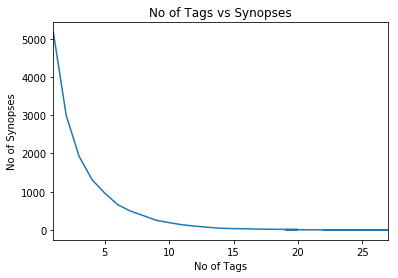

In [5]:
df["tag_count"] = df["tags"].apply(lambda text: len(text.split(" ")))
#Sorting data according to imdb_id in ascending order
sorted_data=df.sort_values('imdb_id', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
df=sorted_data.drop_duplicates(subset={"imdb_id","title","plot_synopsis"}, keep='first', inplace=False)
print(df.shape)
# distribution of number of tags per question
df.tag_count.value_counts().plot()
plt.title('No of Tags vs Synopses')
plt.xlabel('No of Tags')
plt.ylabel('No of Synopses')
plt.show()

Analysis of Tags

In [6]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary=False)

tag_dtm = vectorizer.fit_transform(df['tags'])
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])
tags = vectorizer.get_feature_names()
print("Some of the tags we have :", tags[0:10])

Number of data points : 14828
Number of unique tags : 147
Some of the tags we have : ['absurd', 'absurd,', 'action', 'action,', 'adult', 'allegory', 'allegory,', 'alternate', 'anti', 'atmospheric']


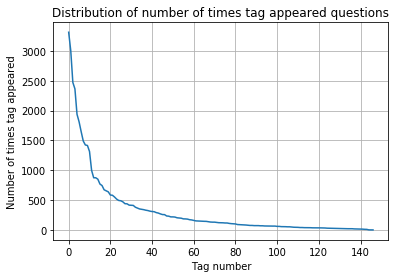

In [7]:
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
# tag_df.head()
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

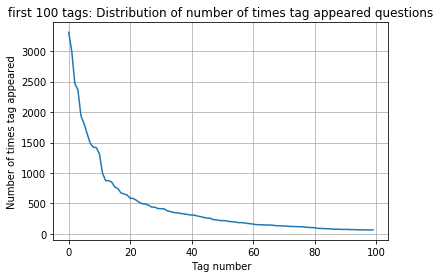

20 [3311 1811 1315  770  586  490  415  347  310  259  220  187  161  146
  132  118  102   84   74   68]


In [8]:
plt.plot(tag_counts[0:100])
plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

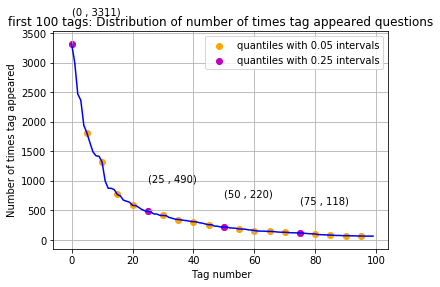

20 [3311 1811 1315  770  586  490  415  347  310  259  220  187  161  146
  132  118  102   84   74   68]


In [9]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

Tags per movie

In [10]:
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 14828 datapoints.
[2, 1, 1, 2, 2]


Maximum number of tags per movie: 27
Minimum number of tags per movie: 1
Avg. number of tags per movie: 3.248854


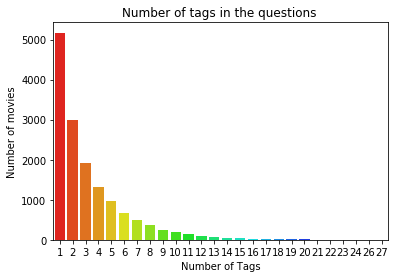

In [11]:
print( "Maximum number of tags per movie: %d"%max(tag_quest_count))
print( "Minimum number of tags per movie: %d"%min(tag_quest_count))
print( "Avg. number of tags per movie: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of movies")
plt.show()

Most frequent tags

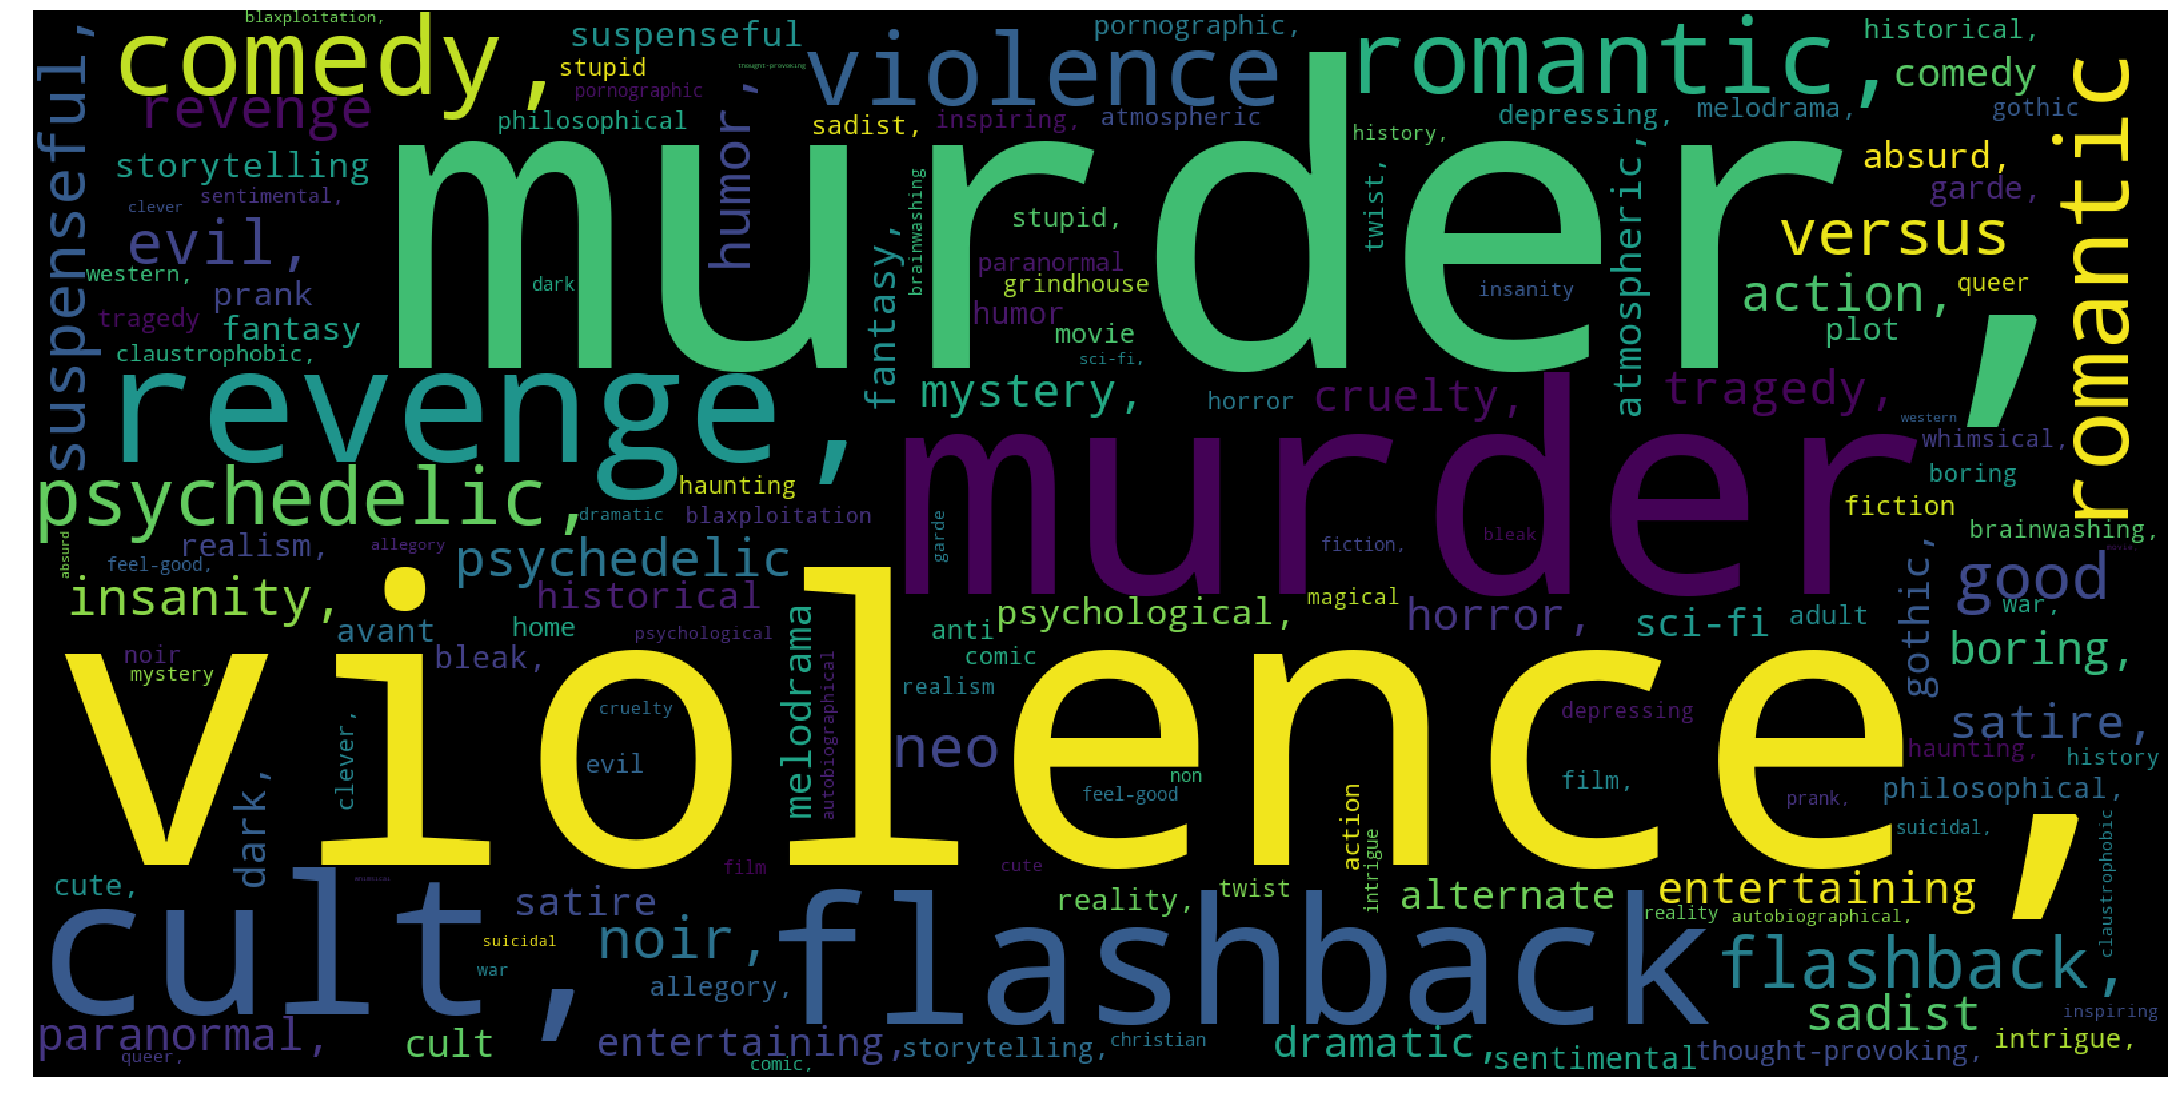

Time taken to run this cell : 0:00:02.816360


In [12]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)


Top 20 Tags

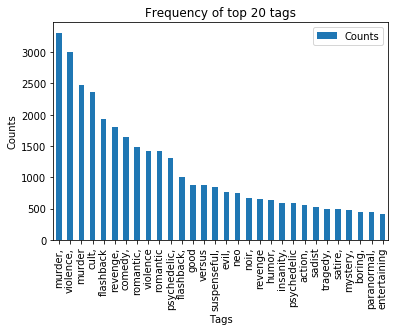

In [13]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()


Tags per Synopsis

We have total 14828 datapoints.
Maximum number of tags per question: 27
Minimum number of tags per question: 1
Avg. number of tags per question: 3.248854


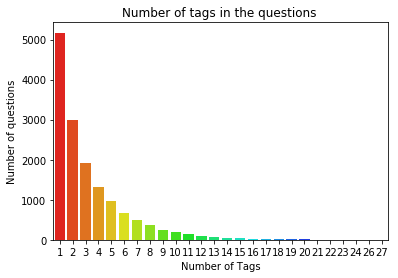

In [14]:
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

In [15]:
import re
from tqdm import tqdm
from bs4 import BeautifulSoup
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
# tqdm is for printing the status bar
preprocessed_synopsis=[]
for sentance in tqdm(df['plot_synopsis'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() )
    preprocessed_synopsis.append(sentance.strip())

100%|██████████| 14828/14828 [00:40<00:00, 362.47it/s]


In [16]:
preprocessed_synopsis[0]

'the film opens with a large bat flying into a medieval castle the bat circles the room before suddenly changing into mephistopheles an incarnation of the devil mephistopheles produces a cauldron and an assistant who helps him conjure a woman from the cauldron the room is cleared shortly before two cavaliers enter the devil is assistant pokes their backs before instantaneously transporting to different areas of the room confusing the pair and causing one to flee the second stays and has several other tricks played on him such as furniture being moved around and the sudden appearance of a skeleton the cavalier is unfazed using a sword to attack the skeleton which then turns into a bat then into mephistopheles who conjures four spectres to subdue the man recovering from the spectres attack the man is visibly dazed and is brought the woman from the cauldron who impresses him with her beauty mephistopheles then turns her into a withered old crone in front of the man is eyes then again into

Converting tags for multilabel problems

In [17]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

(14828, 147)


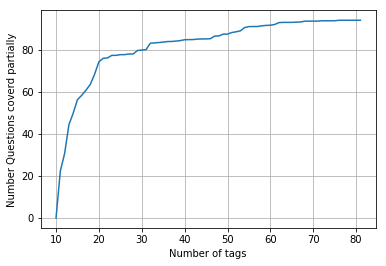

with  50 tags we are covering  91.867 % of questions


In [18]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary=None)
# ths is correct only
# but once you have it done, we need to check the contents of the multilabel_y
multilabel_y = vectorizer.fit_transform(df['tags'])

print(multilabel_y.shape)

questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=df.shape[0]
for i in range(72):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(np.array(range(72))*10)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",50,"tags we are covering ",questions_explained[50],"% of questions")

In [19]:
multilabel_yx = tags_to_choose(50)
print("number of questions that are not covered :", questions_explained_fn(50),"out of ", total_qs)

number of questions that are not covered : 1206 out of  14828


In [20]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 147
number of tags taken : 50 ( 34.01360544217687 %)


In [21]:
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
x=preprocessed_synopsis
y=multilabel_yx
# x_train, x_val, y_train, y_val = train_test_split(preprocessed_synopsis, multilabel_yx, test_size=0.1, random_state=1)

In [59]:
x[0]

'the film opens with a large bat flying into a medieval castle the bat circles the room before suddenly changing into mephistopheles an incarnation of the devil mephistopheles produces a cauldron and an assistant who helps him conjure a woman from the cauldron the room is cleared shortly before two cavaliers enter the devil is assistant pokes their backs before instantaneously transporting to different areas of the room confusing the pair and causing one to flee the second stays and has several other tricks played on him such as furniture being moved around and the sudden appearance of a skeleton the cavalier is unfazed using a sword to attack the skeleton which then turns into a bat then into mephistopheles who conjures four spectres to subdue the man recovering from the spectres attack the man is visibly dazed and is brought the woman from the cauldron who impresses him with her beauty mephistopheles then turns her into a withered old crone in front of the man is eyes then again into

In [23]:
print("Averge text length", np.mean(df['plot_synopsis'].apply(lambda s: len(s))))
print("Min text length", min(df['plot_synopsis'].apply(lambda s: len(s))))
print("Max text length", max(df['plot_synopsis'].apply(lambda s: len(s))))

Averge text length 5139.938090099811
Min text length 442
Max text length 63959


In [89]:
from keras import backend as K
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Dense, Flatten, LSTM, Conv1D, Conv2D, MaxPooling1D, Dropout, Activation,GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import Adam
from time import time
from keras.callbacks import TensorBoard
from keras.layers import Dense, Activation, Embedding, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

from keras.layers.embeddings import Embedding
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [26]:
embeddings_index = {}

with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embeddings_index[word]=vectors
f.close()


In [27]:
print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [28]:
df.columns

Index(['imdb_id', 'title', 'plot_synopsis', 'tags', 'split', 'synopsis_source',
       'tag_count'],
      dtype='object')

In [33]:
tokenizer = Tokenizer(num_words=40000)
tokenizer.fit_on_texts(df['plot_synopsis'])
sequences = tokenizer.texts_to_sequences(df['plot_synopsis'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 153764 unique tokens.


In [46]:
a=list(word_index.keys())
print(len(set(a)))
a[15376]

153764


'hoffmann'

In [60]:
data = pad_sequences(sequences, maxlen=10000)
labels = y
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (14828, 10000)
Shape of label tensor: (14828, 50)


In [63]:
x_train, x_val, y_train, y_val = train_test_split(data, y, test_size=0.2, random_state=10)


In [64]:
# embeddings_index = {}
# with open('/kaggle/input/glove6b100dtxt/glove.6B.100d.txt','r') as f:
#     for line in f:
#         values=line.split()
#         word=values[0]
#         vectors=np.asarray(values[1:],'float32')
#         embeddings_index[word]=vectors
# f.close()


In [ ]:
embeddings_matrix = np.random.random((len(embeddings_index) + 1, 100))
for word, i in embeddings_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embeddings_matrix[i] = embedding_vector

In [62]:
max_features = 40000
max_text_length = 10000
embedding_dims = 100
filters = 250
kernel_size = 3
hidden_dims = 250
batch_size = 512
epochs = 2

In [68]:
num_words = min(40000, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, 100))
for word, i in word_index.items():
    if i >= 40000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [69]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(11862, 10000) (11862, 50)
(2966, 10000) (2966, 50)


In [86]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [104]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [74]:
embedding_layer = Embedding(num_words,100,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=10000,
                            trainable=False)
## 100 is embeding dim
## 10000 is the padded input length

https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2

In [94]:
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_f1micro', verbose=0, save_best_only=True, mode='max')
# checkpoint = ModelCheckpoint(filepath, monitor='val_f1micro', verbose=0, save_best_only=True, mode='max')

### Model 1 using CNNs for Text

In [95]:
# train a 1D convnet with global maxpooling
# Working Model Commented
sequence_input = Input(shape=(10000,), dtype='int32') ## 10000 is max seq length after padding
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(50, activation='softmax')(x)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=[f1_m])
callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=4),
    ModelCheckpoint(filepath='model-simple1.hdf5', save_best_only=True)
]
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 10000)             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10000, 100)        4000000   
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 9996, 128)         64128     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 1999, 128)         0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 1995, 128)         82048     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 399, 128)          0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 395, 128)          8204

In [98]:
history=model.fit(x_train, y_train,batch_size=batch_size,
          epochs=7,validation_data=(x_val, y_val),
                 callbacks=callbacks)

Train on 11862 samples, validate on 2966 samples
Epoch 1/7
11862/11862 [==============================] - 11s 958us/step - loss: 15134491.2524 - f1_m: 0.0439 - val_loss: 19412604.6298 - val_f1_m: 0.0478
Epoch 2/7
11862/11862 [==============================] - 11s 956us/step - loss: 21458225.7498 - f1_m: 0.0473 - val_loss: 31054474.8928 - val_f1_m: 0.1118
Epoch 3/7
11862/11862 [==============================] - 11s 962us/step - loss: 31554662.5905 - f1_m: 0.0469 - val_loss: 35297518.6837 - val_f1_m: 0.0325
Epoch 4/7
11862/11862 [==============================] - 11s 957us/step - loss: 40373651.3074 - f1_m: 0.0541 - val_loss: 47992217.2192 - val_f1_m: 0.0113
Epoch 5/7
11862/11862 [==============================] - 11s 957us/step - loss: 45147124.2624 - f1_m: 0.0451 - val_loss: 56101773.2596 - val_f1_m: 0.0325


Test score: 11.335926561362022
Test accuracy: 0.08386744558811188


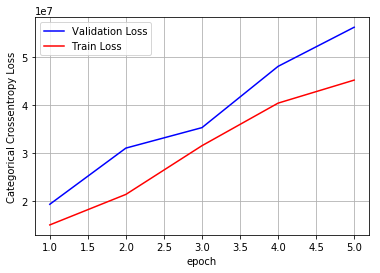

In [106]:
score = model.evaluate(x_val, y_val, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,5+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [77]:
# # train a 1D convnet with global maxpooling
# # Working Model Commented
# sequence_input = Input(shape=(10000,), dtype='int32') ## 10000 is max seq length after padding
# embedded_sequences = embedding_layer(sequence_input)
# x = Conv1D(128, 5, activation='relu')(embedded_sequences)
# x = MaxPooling1D(5)(x)
# x = Conv1D(128, 5, activation='relu')(x)
# x = MaxPooling1D(5)(x)
# x = Conv1D(128, 5, activation='relu')(x)
# x = GlobalMaxPooling1D()(x)
# x = Dense(128, activation='relu')(x)
# preds = Dense(50, activation='softmax')(x)
# model = Model(sequence_input, preds)
# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['acc'])
# model.summary()

### Model 2

In [109]:
sequence_input = Input(shape=(10000,), dtype='int32') ## 10000 is max seq length after padding
embedded_sequences = embedding_layer(sequence_input)
x= Dropout(0.2)(embedded_sequences)
x = Conv1D(512, 3, activation='relu')(x)
x = MaxPooling1D()(x)
# x = Conv1D(256, 3, activation='relu')(x)
# x = MaxPooling1D()(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x= Dropout(0.2)(x)
x = Dense(100, activation='relu')(x)
preds = Dense(50, activation='sigmoid')(x)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[f1_m])
callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=4),
    ModelCheckpoint(filepath='model-simple1.hdf5', save_best_only=True)
]
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 10000)             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10000, 100)        4000000   
_________________________________________________________________
dropout_9 (Dropout)          (None, 10000, 100)        0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 9998, 512)         154112    
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 4999, 512)         0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 4997, 128)         196736    
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 128)               0  

In [115]:
history=model.fit(x_train, y_train,batch_size=128,
          epochs=100,validation_data=(x_val, y_val),
                 callbacks=callbacks)

Train on 11862 samples, validate on 2966 samples
Epoch 1/100
11862/11862 [==============================] - 42s 4ms/step - loss: 8.9471 - f1_m: 0.3042 - val_loss: 9.6305 - val_f1_m: 0.3101
Epoch 2/100
11862/11862 [==============================] - 42s 4ms/step - loss: 8.8668 - f1_m: 0.3119 - val_loss: 9.5559 - val_f1_m: 0.3058
Epoch 3/100
11862/11862 [==============================] - 42s 4ms/step - loss: 8.7950 - f1_m: 0.3168 - val_loss: 9.5669 - val_f1_m: 0.3078
Epoch 4/100
11862/11862 [==============================] - 42s 4ms/step - loss: 8.7456 - f1_m: 0.3173 - val_loss: 9.5073 - val_f1_m: 0.3007
Epoch 5/100
11862/11862 [==============================] - 42s 4ms/step - loss: 8.6607 - f1_m: 0.3212 - val_loss: 9.5142 - val_f1_m: 0.3115
Epoch 6/100
11862/11862 [==============================] - 42s 4ms/step - loss: 8.5948 - f1_m: 0.3233 - val_loss: 9.5274 - val_f1_m: 0.3045
Epoch 7/100
11862/11862 [==============================] - 42s 4ms/step - loss: 8.5153 - f1_m: 0.3266 - val_los

Test score: 9.651271628433197
Test F1: 0.29849398136138916


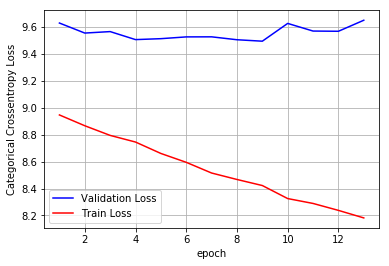

In [117]:
score = model.evaluate(x_val, y_val, verbose=0) 
print('Test score:', score[0]) 
print('Test F1:', score[1])

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,13+1))

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [123]:
sequence_input = Input(shape=(10000,), dtype='int32') ## 10000 is max seq length after padding
embedded_sequences = embedding_layer(sequence_input)
x= Dropout(0.2)(embedded_sequences)
x = LSTM(256, activation='relu', return_sequences=True)(x)
# x = MaxPooling1D()(x)
# x = Conv1D(256, 3, activation='relu')(x)
# x = MaxPooling1D()(x)
x = LSTM(128, activation='relu')(x)
# x = GlobalMaxPooling1D()(x)
x= Dropout(0.2)(x)
x = Dense(100, activation='relu')(x)
preds = Dense(50, activation='sigmoid')(x)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[f1_m])
callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=4),
    ModelCheckpoint(filepath='model-simple1.hdf5', save_best_only=True)
]
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 10000)             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10000, 100)        4000000   
_________________________________________________________________
dropout_16 (Dropout)         (None, 10000, 100)        0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10000, 256)        365568    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               129

In [126]:
# history=model.fit(x_train, y_train,batch_size=32,
#           epochs=1,validation_data=(x_val, y_val),
#                  callbacks=callbacks)

Train on 11862 samples, validate on 2966 samples
Epoch 1/1
 2976/11862 [======>.......................] - ETA: 2:03:08 - loss: 0.6641 - f1_m: 0.0022

KeyboardInterrupt: 